# Tutorial 7: Assembling custom pipelines

In [1]:
import homelette as hm

import matplotlib as plt
import seaborn as sns

/home/junkpp/work/programs/homelette/homelette/__init__.py:68: UserWarning: Module "altmod" could not be imported.
  warnings.warn(msg)
/home/junkpp/work/programs/homelette/homelette/__init__.py:68: UserWarning: Module "ost" could not be imported.
  warnings.warn(msg)
/home/junkpp/work/programs/homelette/homelette/__init__.py:68: UserWarning: Module "promod3" could not be imported.
  warnings.warn(msg)
/home/junkpp/work/programs/homelette/homelette/__init__.py:68: UserWarning: Module "qmean" could not be imported.
  warnings.warn(msg)
/home/junkpp/work/programs/homelette/homelette/__init__.py:73: UserWarning: Please install the missing modules in order to enjoy the full functionality of "homology"
  warnings.warn(msg)


## Introduction

Welcome to the final tutorial on `homelette`. This tutorial is about combining what we learnt in the previous tutorials about model generating and model evaluating building blocks.

The strength of `homelette` lies in its ability to *A)* be almost freely extendable by the user (see **Tutorial 4**) and *B)* in the ease with which pre-defined or custom-made building blocks for model generation and evaluation can be assembled into custom pipelines. This tutorial showcases *B)*.

For our target sequence, ARAF, we will identify templates and generate alignments with the `AlignmentGenerator_pdb` building block [1,2,3,4]. We will select two templates, BRAF ([3NY5](https://www.rcsb.org/structure/3NY5)) and RAF1 ([4G0N](https://www.rcsb.org/structure/4G0N)). We will build models for ARAF with two different routines, `Routine_automodel_default` and `Routine_automodel_slow` [5,6], and from the different templates. The generated models will be evaluated by SOAP scores and MolProbity and a combined score will be calculated using Borda Count [7,8,9,10]. 

## Alignment

Consistent with the other tutorials, we will be modelling the protein ARAF. For this tutorial, we will use the `AlignmentGenerator_pdb` in order to search for templates, create an alignment, and process both the templates as well as the alignment:


In [2]:
gen = hm.alignment.AlignmentGenerator_pdb.from_fasta('data/alignments/ARAF.fa')

In [3]:
# search for templates and generate first alignment
gen.get_suggestion()
gen.show_suggestion()

Querying PDB...
Query successful, 16 found!

Retrieving sequences...
Sequences succefully retrieved!

Generating alignment...
Alignment generated!

Query successful.
17 sequences have been found.


,template,coverage,identity
0,4G0N_2,100.0,60.27
1,6VJJ_2,100.0,60.27
2,6XHA_2,100.0,60.27
5,1C1Y_2,100.0,60.27
6,1GUA_2,100.0,60.27
8,4G3X_2,100.0,60.27
11,6XGU_2,100.0,60.27
12,6XGV_2,100.0,60.27
13,6XHB_2,100.0,60.27
14,6XI7_2,100.0,60.27


For this example, we will choose one template of BRAF (3NY5) and one template from RAF1 (4G0N):

In [4]:
# select templates and show alignment
gen.select_templates(['3NY5_1', '4G0N_2'])
gen.alignment.print_clustal(70)

ARAF        -------------GTVKVYLPNKQRTVVTVRDGMSVYDSLDKALKVRGLNQDCCVVYRLI---KGRKTVT
3NY5_1      MGHHHHHHSHMQKPIVRVFLPNKQRTVVPARCGVTVRDSLKKALMMRGLIPECCAVYRIQ---DGEKKPI
4G0N_2      -----------TSNTIRVFLPNKQRTVVNVRNGMSLHDCLMKALKVRGLQPECCAVFRLLHEHKGKKARL


ARAF        AWDTAIAPLDGEELIVEVL----------
3NY5_1      GWDTDISWLTGEELHVEVLENVPLTTHNF
4G0N_2      DWNTDAASLIGEELQVDFL----------




Next, we download the template structures and process both the alignment and the structures:

In [5]:
# download structures, process alignment and structures
gen.get_pdbs()
gen.show_suggestion()

Guessing template naming format...
Template naming format guessed: polymer_entity!

Checking template dir...
Template dir found!

Processing templates:

3NY5 downloading from PDB...
3NY5 downloaded!
3NY5_A: Chain extracted!
3NY5_A: Alignment updated!
3NY5_A: PDB processed!
3NY5_B: Chain extracted!
3NY5_B: Alignment updated!
3NY5_B: PDB processed!
3NY5_C: Chain extracted!
3NY5_C: Alignment updated!
3NY5_C: PDB processed!
3NY5_D: Chain extracted!
3NY5_D: Alignment updated!
3NY5_D: PDB processed!
4G0N downloading from PDB...
4G0N downloaded!
4G0N_B: Chain extracted!
4G0N_B: Alignment updated!
4G0N_B: PDB processed!

Finishing... All templates successfully
downloaded and processed!
Templates can be found in
"/home/junkpp/work/programs/homelette/examples/templates".


,template,coverage,identity
4,4G0N_B,100.00,60.27
1,3NY5_B,94.52,57.53
0,3NY5_A,93.15,57.53
2,3NY5_C,93.15,57.53
3,3NY5_D,91.78,57.53


We can see that there are multiple chains of 3NY5 that fit our alignment. One of the chains has less missing residues than the other ones, so we are choosing this one:

In [6]:
# select templates
gen.select_templates(['4G0N_B', '3NY5_B'])
gen.alignment.print_clustal(70)
gen.show_suggestion()

ARAF        ----GTVKVYLPNKQRTVVTVRDGMSVYDSLDKALKVRGLNQDCCVVYRLI---KGRKTVTAWDTAIAPL
4G0N_B      --TSNTIRVFLPNKQRTVVNVRNGMSLHDCLMKALKVRGLQPECCAVFRLLHEHKGKKARLDWNTDAASL
3NY5_B      SHQKPIVRVFLPNKQRTVVPARCGVTVRDSLKKAL--RGLIPECCAVYRIQ-----EKKPIGWDTDISWL


ARAF        DGEELIVEVL--------
4G0N_B      IGEELQVDFL--------
3NY5_B      TGEELHVEVLENVPLTTH




,template,coverage,identity
0,4G0N_B,100.00,60.27
1,3NY5_B,94.52,57.53


Now that we have our templates prepared and aligned, we can now define a custom `Task` object in order to assemble `homelette` building blocks into a pipeline:

## Custom pipeline

The easiest way to formulate custom pipelines by assembling the `homelette` building blocks of model building and evaluation is to construct custom `Task` objects:

In [13]:
class CustomPipeline(hm.Task):
    '''
    Example for a cumstom pipeline
    '''
    def model_generation(self, templates):
        # model generation with automodel_default
        self.execute_routine(tag='automodel_def_' + '-'.join(templates),
                             routine = hm.routines.Routine_automodel_default,
                             templates = templates,
                             template_location = './templates/',
                             n_models = 20,
                             n_threads = 5)
        # model generation with autmodel_slow
        self.execute_routine(tag='autmodel_slow_' + '-'.join(templates),
                             routine = hm.routines.Routine_automodel_slow,
                             templates = templates,
                             template_location = './templates/',
                             n_models = 20,
                             n_threads = 5)
        
    def model_evaluation(self):
        # perform evaluation
        self.evaluate_models(hm.evaluation.Evaluation_mol_probity,
                             n_threads=5)
        self.evaluate_models(hm.evaluation.Evaluation_soap_protein)
        ev = self.get_evaluation()
        # borda count for best models
        ev['points_soap'] = ev.shape[0] - ev['soap_protein'].rank()
        ev['points_mol_probity'] = ev.shape[0] - ev['mp_score'].rank()
        ev['borda_score'] = ev['points_soap'] + ev['points_mol_probity']
        ev['borda_rank'] = ev['borda_score'].rank(ascending=False)
        ev = ev.drop(labels=['points_soap', 'points_mol_probity'], axis=1)
        return ev

We have constructed a custom `Task` object (more specifically, a custom objects that inherits all methods and attributes from `Task`) and added two more functions: `model_generation` and `model_evaluation`.

In `CustomPipeline.model_generation` we are using two routines (`Routine_automodel_default` and `Routine_automodel_slow`) to generate 20 models each. In `CustomPipeline.model_generation` we evaluate the models using `Evaluation_mol_probity` and `Evaluation_soap_protein` and then rank the generated models based on both evaluation metrics using Borda Count.

After constructing our pipeline, let's execute it with two different templates as an example:

After having a custom `Task` object defined, we can initialize it from the `AlignmentGenerator` in order to do the modelling and evaluation:

In [14]:
# initialize task from alignment generator
t = gen.initialize_task(
    task_name = 'Tutorial7', 
    overwrite = True, 
    task_class = CustomPipeline)

In [15]:
# execute pipeline for different templates
t.model_generation(['3NY5_B'])
t.model_generation(['4G0N_B'])

df_eval = t.model_evaluation()

ModellerError: hdf5err____E> unable to open file


We have successfully generated and evaluated 80 models.

In [7]:
# get template from tag
df_eval['template'] = df_eval['tag'].str.contains('3NY5').map({True: '3NY5', False: '4G0N'})

In [8]:
df_eval.sort_values(by = 'borda_rank').head(10)

,model,tag,routine,mp_score,soap_protein,borda_score,borda_rank,template
64,autmodel_slow_4G0N_5.pdb,autmodel_slow_4G0N,automodel_slow,2.21,-45545.746094,148.0,1.0,4G0N
28,autmodel_slow_3NY5_9.pdb,autmodel_slow_3NY5,automodel_slow,2.31,-45972.250000,145.0,2.0,3NY5
77,autmodel_slow_4G0N_18.pdb,autmodel_slow_4G0N,automodel_slow,2.17,-45043.023438,144.0,3.0,4G0N
24,autmodel_slow_3NY5_5.pdb,autmodel_slow_3NY5,automodel_slow,2.42,-46180.289062,138.0,4.0,3NY5
69,autmodel_slow_4G0N_10.pdb,autmodel_slow_4G0N,automodel_slow,2.29,-45205.257812,137.0,5.0,4G0N
63,autmodel_slow_4G0N_4.pdb,autmodel_slow_4G0N,automodel_slow,2.26,-44921.707031,134.0,6.0,4G0N
22,autmodel_slow_3NY5_3.pdb,autmodel_slow_3NY5,automodel_slow,2.49,-48465.539062,132.5,7.0,3NY5
72,autmodel_slow_4G0N_13.pdb,autmodel_slow_4G0N,automodel_slow,2.20,-44206.707031,131.0,8.0,4G0N
79,autmodel_slow_4G0N_20.pdb,autmodel_slow_4G0N,automodel_slow,2.24,-44585.621094,130.5,9.0,4G0N
33,autmodel_slow_3NY5_14.pdb,autmodel_slow_3NY5,automodel_slow,2.50,-45825.039062,125.5,10.0,3NY5


We can see that most of the best 10 models were generated with the slower routine `Routine_autmodel_slow`. This is to be expected, as this routine spends more time on model refinement and should therefore produce "better" models.

Next, we visualize the results of our evaluation with `seaborn`.

## Visualization

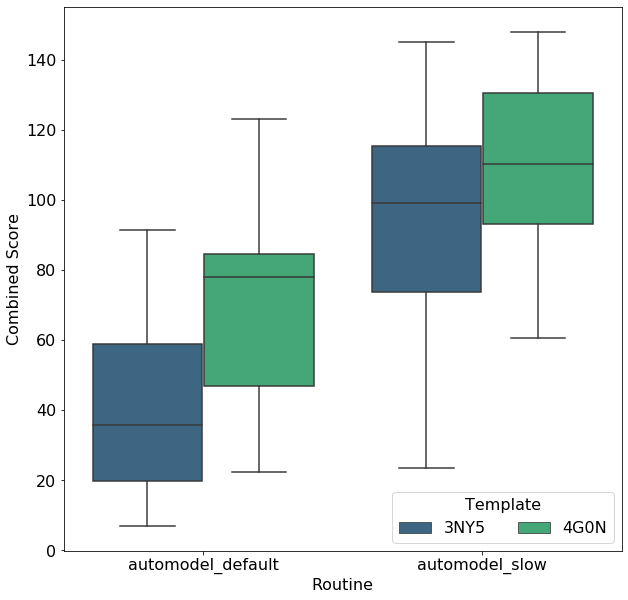

In [9]:
# visualize combined score with seaborn
%matplotlib inline

# set font size
plt.rcParams.update({'font.size': 16})

plot = sns.boxplot(x = 'routine', y = 'borda_score', hue='template', data=df_eval,
                   palette='viridis')
plot.set(xlabel = 'Routine')
plot.set(ylabel = 'Combined Score')
plot.figure.set_size_inches(10, 10)
plot.legend(title = 'Template', loc = 'lower right', ncol = 2, fancybox = True)
#plot.figure.savefig('tutorial7.png', dpi=300)

As expected, the routine which spends more time on model refinement (`Routine_automodel_slow`) produces on average better results. Also, there are interesting differences between the templates used.

## Further Reading

Congratulations on finishing the final tutorial about `homelette`. You might also be interested in the other tutorials:

- **Tutorial 1**: Learn about the basics of `homelette`.
- **Tutorial 2**: Learn more about already implemented routines for homology modelling.
- **Tutorial 3**: Learn about the evaluation metrics available with `homelette`.
- **Tutorial 4**: Learn about extending `homelette`'s functionality by defining your own modelling routines and evaluation metrics.
- **Tutorial 5**: Learn about how to use parallelization in order to generate and evaluate models more efficiently.
- **Tutorial 6**: Learn about modelling protein complexes.
- **Tutorial 8**: Learn about automated template identification, alignment generation and template processing.

## References

[1] Rose, Y., Duarte, J. M., Lowe, R., Segura, J., Bi, C., Bhikadiya, C., Chen, L., Rose, A. S., Bittrich, S., Burley, S. K., & Westbrook, J. D. (2021). RCSB Protein Data Bank: Architectural Advances Towards Integrated Searching and Efficient Access to Macromolecular Structure Data from the PDB Archive. Journal of Molecular Biology, 433(11), 166704. https://doi.org/10.1016/J.JMB.2020.11.003

[2] Steinegger, M., & Söding, J. (2017). MMseqs2 enables sensitive protein sequence searching for the analysis of massive data sets. Nature Biotechnology 2017 35:11, 35(11), 1026–1028. https://doi.org/10.1038/nbt.3988

[3] Sievers, F., Wilm, A., Dineen, D., Gibson, T. J., Karplus, K., Li, W., Lopez, R., McWilliam, H., Remmert, M., Söding, J., Thompson, J. D., & Higgins, D. G. (2011). Fast, scalable generation of high-quality protein multiple sequence alignments using Clustal Omega. Molecular Systems Biology, 7(1), 539. https://doi.org/10.1038/MSB.2011.75

[4] Sievers, F., & Higgins, D. G. (2018). Clustal Omega for making accurate alignments of many protein sequences. Protein Science, 27(1), 135–145. https://doi.org/10.1002/PRO.3290

[5] Šali, A., & Blundell, T. L. (1993). Comparative protein modelling by satisfaction of spatial restraints. Journal of Molecular Biology, 234(3), 779–815. https://doi.org/10.1006/jmbi.1993.1626

[6] Webb, B., & Sali, A. (2016). Comparative Protein Structure Modeling Using MODELLER. Current Protocols in Bioinformatics, 54(1), 5.6.1-5.6.37. https://doi.org/10.1002/cpbi.3

[7] Dong, G. Q., Fan, H., Schneidman-Duhovny, D., Webb, B., Sali, A., & Tramontano, A. (2013). Optimized atomic statistical potentials: Assessment of protein interfaces and loops. Bioinformatics, 29(24), 3158–3166. https://doi.org/10.1093/bioinformatics/btt560

[8] Davis, I. W., Leaver-Fay, A., Chen, V. B., Block, J. N., Kapral, G. J., Wang, X., Murray, L. W., Arendall, W. B., Snoeyink, J., Richardson, J. S., & Richardson, D. C. (2007). MolProbity: all-atom contacts and structure validation for proteins and nucleic acids. Nucleic Acids Research, 35(suppl_2), W375–W383. https://doi.org/10.1093/NAR/GKM216

[9] Chen, V. B., Arendall, W. B., Headd, J. J., Keedy, D. A., Immormino, R. M., Kapral, G. J., Murray, L. W., Richardson, J. S., & Richardson, D. C. (2010). MolProbity: All-atom structure validation for macromolecular crystallography. Acta Crystallographica Section D: Biological Crystallography, 66(1), 12–21. https://doi.org/10.1107/S0907444909042073

[10] Williams, C. J., Headd, J. J., Moriarty, N. W., Prisant, M. G., Videau, L. L., Deis, L. N., Verma, V., Keedy, D. A., Hintze, B. J., Chen, V. B., Jain, S., Lewis, S. M., Arendall, W. B., Snoeyink, J., Adams, P. D., Lovell, S. C., Richardson, J. S., & Richardson, D. C. (2018). MolProbity: More and better reference data for improved all-atom structure validation. Protein Science, 27(1), 293–315. https://doi.org/10.1002/pro.3330


## Session Info

In [10]:
# session info
import session_info
session_info.show(html = False, dependencies = True)

-----
homelette           1.0
matplotlib          3.1.2
pandas              0.25.3
seaborn             0.11.2
session_info        1.0.0
-----
PIL                         7.0.0
altmod                      NA
anyio                       NA
attr                        19.3.0
babel                       2.9.1
backcall                    0.2.0
certifi                     2021.05.30
chardet                     3.0.4
charset_normalizer          2.0.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.7.3
debugpy                     1.4.1
decorator                   4.4.2
entrypoints                 0.3
idna                        3.2
ipykernel                   6.3.1
ipython_genutils            0.2.0
jedi                        0.18.0
jinja2                      3.0.1
json5                       NA
jsonschema                  3.2.0
jupyter_server              1.10.2
jupyterlab_server           2.8.0
kiwisolver                  1.0.1
markupsafe     